# Home Deco Business Analysis - Statistical Tests

This notebook contains statistical analysis of the Home Deco business data, including:
1. Correlation Analysis
2. Hypothesis Testing

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [15]:
# Load the datasets
daily_clients = pd.read_excel('../data/daily_clients.xlsx')
monthly_sales = pd.read_excel('../data/monthly_sales_ads_data.xlsx')
daily_web = pd.read_excel('../data/daily_web_traffic.xlsx')

## 1. Correlation Analysis
Analyzing relationships between sales, web traffic, and marketing metrics

In [16]:
# Analyze correlations between key metrics 
metrics = [
    'subtotal_usd', 'n_items', 'unique_clients',
    'clics', 'impresiones', 'costo_ads_usd', 'visitas_web'
]

corr_matrix = monthly_sales[metrics].corr()
corr_matrix

,subtotal_usd,n_items,unique_clients,clics,impresiones,costo_ads_usd,visitas_web
subtotal_usd,1.00,0.65,0.39,0.19,0.30,0.22,0.22
n_items,0.65,1.00,0.74,0.47,0.57,0.57,0.55
unique_clients,0.39,0.74,1.00,0.54,0.72,0.76,0.69
clics,0.19,0.47,0.54,1.00,0.77,0.76,0.86
impresiones,0.30,0.57,0.72,0.77,1.00,0.91,0.79
costo_ads_usd,0.22,0.57,0.76,0.76,0.91,1.00,0.87
visitas_web,0.22,0.55,0.69,0.86,0.79,0.87,1.00


1. Sales Performance Metrics:
- subtotal_usd (revenue) has strongest correlation with n_items (0.65), suggesting sales volume is a key driver of revenue
- Interestingly, revenue has relatively weak correlations with marketing metrics (0.19-0.30), indicating that higher marketing spend or activity doesn't directly translate to higher revenue
2. Customer Behavior:
- unique_clients shows strong correlation with n_items (0.74), indicating that more unique customers lead to more items sold
- unique_clients also correlates well with marketing metrics (impresiones: 0.72, costo_ads_usd: 0.76), suggesting marketing efforts are effective at attracting new customers
3. Marketing Funnel:
- Strong correlation between impresiones and costo_ads_usd (0.91) - as expected, more ad spend leads to more impressions
- Clear funnel progression: impresiones → clics → visitas_web
- impresiones to clics: 0.77
- clics to visitas_web: 0.86
- This shows good conversion through the marketing funnel
4. Website Traffic:
- visitas_web has strong correlations with marketing metrics (clics: 0.86, costo_ads_usd: 0.87)
- However, it has relatively weak correlation with subtotal_usd (0.22), suggesting that driving traffic alone doesn't guarantee sales
5. Cost Efficiency:
- costo_ads_usd has stronger correlation with unique_clients (0.76) than with subtotal_usd (0.22)
- This suggests ad spend is better at acquiring new customers than driving revenue directly

#### Key Takeaways:
Marketing efforts are effective at driving traffic and acquiring new customers
There's a disconnect between marketing metrics and actual revenue
The number of items sold is more closely tied to revenue than any marketing metric
The marketing funnel shows good conversion rates between stages
There might be opportunity to improve conversion from website visits to actual sales

In [17]:
# Test correlation between ad spend and sales
correlation, p_value = stats.pearsonr(
    monthly_sales['costo_ads_usd'],
    monthly_sales['subtotal_usd']
)

print(
    f'correlation: {correlation:.3f}, '
    f'p_value: {p_value:.4f}'
)

correlation: 0.224, p_value: 0.1641


In [18]:
# Test if there's a significant difference in traffic between weekdays and weekends
'''
The null hypothesis in this case would be: 
H₀: There is no significant difference between weekday and weekend traffic (weekday_mean = weekend_mean) 
H₁: There is a significant difference between weekday and weekend traffic (weekday_mean ≠ weekend_mean)

'''

daily_web['Fecha'] = pd.to_datetime(daily_web['Fecha'])
daily_web['is_weekend'] = daily_web['Fecha'].dt.dayofweek.isin([5, 6])

weekday_traffic = daily_web[~daily_web['is_weekend']]['visitas_web']
weekend_traffic = daily_web[daily_web['is_weekend']]['visitas_web']

t_stat, p_value = stats.ttest_ind(weekday_traffic, weekend_traffic)

print(
    f'weekday_mean: {weekday_traffic.mean():.2f}, '
    f'weekend_mean: {weekend_traffic.mean():.2f}, '
    f't_statistic: {t_stat:.3f}, '
    f'p_value: {p_value:.4f}'
)

weekday_mean: 87.00, weekend_mean: 69.57, t_statistic: 3.608, p_value: 0.0003


Interpretation:

The extremely small p-value (0.0003 < 0.05) indicates strong evidence to reject the null hypothesis
This means there is a statistically significant difference between weekday and weekend traffic
We can be 99.97% confident that this difference is not due to random chance

In [19]:
# Test correlation between ad spend and sales
correlation, p_value = stats.pearsonr(
    monthly_sales['costo_ads_usd'],
    monthly_sales['subtotal_usd']
)

print(
    f'correlation: {correlation:.3f}, '
    f'p_value: {p_value:.4f}'
)

correlation: 0.224, p_value: 0.1641


1. **Correlation Coefficient (r = 0.224):**
- This indicates a weak positive correlation between ad spend and sales
- The scale goes from -1 to +1,
- The value of 0.224 suggests that as ad spend increases, sales do tend to increase, but the relationship is quite weak
2. **P-value (p = 0.1641):**
- This p-value is greater than the common significance level of 0.05
- This means the correlation is not statistically significant
- There's about a 16.41% chance that we could observe this correlation even if there was no true relationship between ad spend and sales

#### Business Interpretation:
The current advertising strategy might not be as effective as desired:
Only 22.4% of the variation in sales might be explained by ad spending
We cannot be confident that the relationship isn't just due to random chance

## Traffic Sales Lag

In [20]:
def analyze_traffic_sales_lag(daily_web, monthly_sales, max_lag=5):
    """
    Analyze the correlation between web traffic and items sold with different time lags
    
    Parameters:
    -----------
    daily_web : DataFrame
        Daily web traffic data with 'Fecha' and 'visitas_web' columns
    monthly_sales : DataFrame
        Monthly sales data with 'dateMonth' and 'n_items' columns
    max_lag : int
        Maximum number of months to lag
        
    Returns:
    --------
    dict with correlation results for each lag and the best lag statistics
    """
    # Convert daily web traffic to monthly, using first day of month
    daily_web['Fecha'] = pd.to_datetime(daily_web['Fecha'])
    monthly_web = (daily_web.set_index('Fecha')
                  .resample('M')['visitas_web']
                  .sum()
                  .reset_index())
    # Convert end of month to first day of month
    monthly_web['Fecha'] = monthly_web['Fecha'].dt.to_period('M').dt.to_timestamp()
    monthly_web.columns = ['dateMonth', 'visitas_web']
    
    # Ensure monthly_sales dateMonth is datetime
    monthly_sales['dateMonth'] = pd.to_datetime(monthly_sales['dateMonth'])
    
    # Merge datasets
    merged_data = pd.merge(
        monthly_web,
        monthly_sales[['dateMonth', 'n_items']],
        on='dateMonth',
        how='inner'
    )
    
    # Calculate correlations for different lags
    lag_results = {}
    for lag in range(max_lag + 1):
        # Create lagged web traffic
        merged_data[f'traffic_lag_{lag}'] = merged_data['visitas_web'].shift(lag)
        
        # Calculate correlation
        if lag == 0:
            correlation, p_value = stats.pearsonr(
                merged_data['visitas_web'],
                merged_data['n_items']
            )
        else:
            correlation, p_value = stats.pearsonr(
                merged_data[f'traffic_lag_{lag}'].dropna(),
                merged_data['n_items'].iloc[lag:]
            )
        
        lag_results[lag] = {
            'correlation': correlation,
            'p_value': p_value
        }
    
    # Find best lag
    best_lag = max(lag_results.items(), key=lambda x: abs(x[1]['correlation']))[0]
    
    return {
        'lag_results': lag_results,
        'best_lag': best_lag,
        'best_correlation': lag_results[best_lag]['correlation'],
        'best_p_value': lag_results[best_lag]['p_value']
    }

R² results for different lags:

Lag 0 month(s):
R²: 0.305
P-value: 0.0002

Lag 1 month(s):
R²: 0.223
P-value: 0.0024

Lag 2 month(s):
R²: 0.320
P-value: 0.0002

Lag 3 month(s):
R²: 0.248
P-value: 0.0017

Lag 4 month(s):
R²: 0.167
P-value: 0.0133

Best lag analysis:
Best lag: 2 month(s)
Best R²: 0.320
P-value: 0.0002


C:\Users\nbuly\AppData\Local\Temp\ipykernel_29768\1960640180.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['visitas_web']


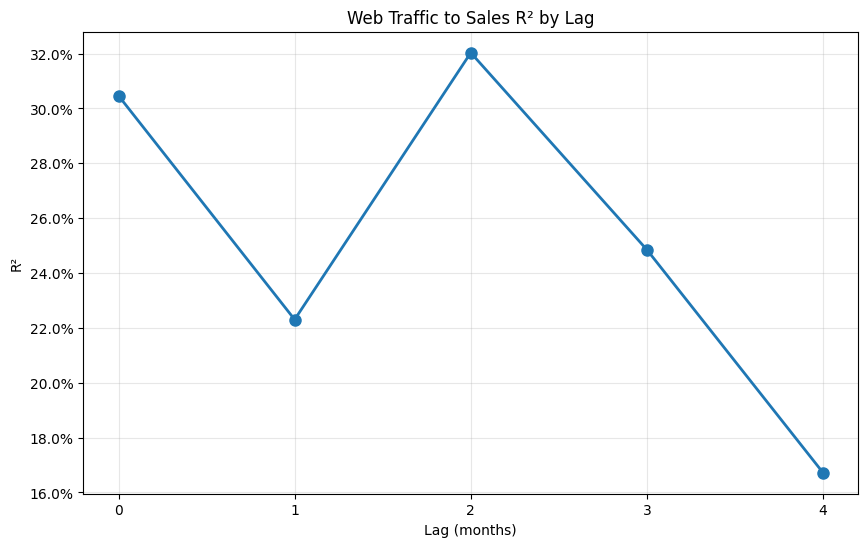

In [21]:
# Analyze lagged correlations between web traffic and sales
lag_analysis = analyze_traffic_sales_lag(daily_web, monthly_sales, max_lag=4)

# Calculate R² values (square of correlation coefficients)
r2_values = {lag: results['correlation']**2 for lag, results in lag_analysis['lag_results'].items()}

# Print results
print("R² results for different lags:")
for lag, r2 in r2_values.items():
    print(f"\nLag {lag} month(s):")
    print(f"R²: {r2:.3f}")
    print(f"P-value: {lag_analysis['lag_results'][lag]['p_value']:.4f}")

print("\nBest lag analysis:")
print(f"Best lag: {lag_analysis['best_lag']} month(s)")
print(f"Best R²: {lag_analysis['best_correlation']**2:.3f}")
print(f"P-value: {lag_analysis['best_p_value']:.4f}")

# Visualize R² values with line plot
plt.figure(figsize=(10, 6))
lags = list(r2_values.keys())
r2_list = list(r2_values.values())

plt.plot(lags, r2_list, marker='o', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Lag (months)')
plt.ylabel('R²')
plt.title('Web Traffic to Sales R² by Lag')
plt.xticks(lags)  # Ensure all lag points are shown on x-axis

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.show()

1. **Statistical Significance:**
- All lags (0-4 months) show p-values < 0.05
- This means we can reject the null hypothesis for all lags
- There is strong evidence of a relationship between web traffic and sales at all tested time periods
2. **Strength of Relationships (R² values):**
- Lag 2 months: Strongest relationship (R² = 0.320, explains 32.0% of variance)
- Lag 0 months: Second strongest (R² = 0.305, explains 30.5% of variance)
- Lag 3 months: (R² = 0.248, explains 24.8% of variance)
- Lag 1 month: (R² = 0.223, explains 22.3% of variance)
- Lag 4 months: Weakest relationship (R² = 0.167, explains 16.7% of variance)
3. **Business Interpretation:**
- The strongest relationship occurs with a 2-month lag (32% explanatory power)
- This suggests that web traffic is most predictive of sales that occur 2 months later
- The immediate relationship (lag 0) is also strong, indicating some customers make quick decisions
- The relationship gradually weakens after 2 months, but remains significant
4. **Customer Journey Insights:**
- Multiple significant lags suggest a varied customer journey:
- Some customers purchase immediately (strong lag 0)
- Peak conversion occurs around 2 months after initial visit
- Effect persists up to 4 months, but with diminishing strength
#### Business Implications:
Marketing campaigns should account for this 2-month average customer journey
Budget for at least 2-3 months of sustained marketing before expecting peak results
Consider retargeting strategies that maintain engagement over this period
The immediate effect (lag 0) suggests that some promotional activities could also drive quick sales

### Purchase Frequency

In [22]:
def analyze_purchase_frequency(daily_clients):
    """
    Analyze if there's a significant difference in purchase behavior between
    customer segments based on purchase frequency
    """
    # Calculate purchases per customer
    customer_purchases = daily_clients.groupby('cliente_id')['cantidad'].agg(['count', 'sum'])
    
    # Segment customers
    customer_purchases['frequency'] = 'one_time'
    customer_purchases.loc[customer_purchases['count'] > 1, 'frequency'] = 'repeat'
    
    # Compare purchase volumes
    one_time = customer_purchases[customer_purchases['frequency'] == 'one_time']['sum']
    repeat = customer_purchases[customer_purchases['frequency'] == 'repeat']['sum']
    
    t_stat, p_value = stats.ttest_ind(one_time, repeat)
    
    return {
        'one_time_avg': one_time.mean(),
        'repeat_avg': repeat.mean(),
        'one_time_count': len(one_time),
        'repeat_count': len(repeat),
        't_statistic': t_stat,
        'p_value': p_value
    }

In [23]:
# Analyze purchase frequency
freq_analysis = analyze_purchase_frequency(daily_clients)
print("Purchase Frequency Analysis:")
print(f"One-time customers (n={freq_analysis['one_time_count']}): {freq_analysis['one_time_avg']:.2f} items/customer")
print(f"Repeat customers (n={freq_analysis['repeat_count']}): {freq_analysis['repeat_avg']:.2f} items/customer")
print(f"P-value: {freq_analysis['p_value']:.4f}")

Purchase Frequency Analysis:
One-time customers (n=951): 2.84 items/customer
Repeat customers (n=141): 7.92 items/customer
P-value: 0.0000


1. **Customer Segmentation:**
- One-time customers: 951 (87.1% of customer base)
- Repeat customers: 141 (12.9% of customer base)
- This shows a significant opportunity to improve customer retention
2. **Purchase Behavior:**
- One-time customers average: 2.84 items/customer
- Repeat customers average: 7.92 items/customer
- Repeat customers buy 2.79x more items than one-time customers
- This represents a significant difference in purchasing behavior
3. **Statistical Significance:**
- P-value < 0.0001 (extremely significant)
- Null hypothesis (H₀: no difference between groups) is strongly rejected
- We can be more than 99.99% confident that this difference is not due to chance
4. **Business Implications:**
- Converting a one-time customer to a repeat customer could lead to ~5 additional items purchased
- With only 12.9% repeat customers, there's a large opportunity for growth
- Potential revenue increase = (951 one-time customers) × (conversion rate) × (5 additional items) × (average item price)
#### Recommendations:
Implement a customer retention program
Consider loyalty rewards or incentives for second purchases
Focus marketing budget on retaining existing customers (typically more cost-effective than acquiring new ones)
Analyze what distinguishes repeat customers (e.g., product categories, price points, marketing channels)
Set up automated follow-up communications with one-time customers

### Price Sensitivity

In [24]:
monthly_sales.head()

,dateMonth,month,yearMonth,quarter,year,quarterYear,n_items,subtotal_usd,unique_clients,clics,impresiones,costo_ads_usd,visitas_web
0,2021-09-01,9,202109,3,2021,2021-Q3,83,7646,37,2768,144654,1648,4450
1,2021-10-01,10,202110,4,2021,2021-Q4,117,10842,38,2389,92091,1063,3506
2,2021-11-01,11,202111,4,2021,2021-Q4,136,13241,53,2309,79006,981,3183
3,2021-12-01,12,202112,4,2021,2021-Q4,143,12971,52,2579,110854,1015,3472
4,2022-01-01,1,202201,1,2022,2022-Q1,144,16961,38,2708,108925,814,3395


In [25]:
def analyze_price_sensitivity(monthly_sales):
    """
    Analyze if there's a significant relationship between price points
    and conversion rates
    """
    # Calculate average price per item for each transaction
    monthly_sales['avg_price'] = monthly_sales['subtotal_usd'] / monthly_sales['n_items']
    
    # Create price segments
    price_segments = pd.qcut(monthly_sales['avg_price'], q=3, labels=['low', 'medium', 'high'])
    monthly_sales['price_segment'] = price_segments
    
    # Calculate statistics for each segment
    segment_stats = monthly_sales.groupby('price_segment').agg({
        'n_items': 'sum',
        'impresiones': 'sum',
        'avg_price': ['mean', 'min', 'max'],
        'subtotal_usd': 'sum'
    })
    
    # Calculate conversion rates
    segment_stats['conversion_rate'] = segment_stats['n_items'] / segment_stats['impresiones']
    
    # Prepare data for ANOVA test
    segments = []
    for segment in ['low', 'medium', 'high']:
        segment_data = monthly_sales[monthly_sales['price_segment'] == segment]
        # Calculate monthly conversion rates for ANOVA
        monthly_conv = segment_data.groupby(pd.to_datetime(segment_data['dateMonth']).dt.to_period('M')).agg({
            'n_items': 'sum',
            'impresiones': 'sum'
        })
        monthly_conv['conv_rate'] = monthly_conv['n_items'] / monthly_conv['impresiones']
        segments.append(monthly_conv['conv_rate'].values)
    
    # Perform ANOVA test
    f_stat, p_value = stats.f_oneway(*segments)
    
    return {
        'segment_stats': segment_stats,
        'f_statistic': f_stat,
        'p_value': p_value
    }

In [26]:
# Analyze purchase frequency
freq_analysis = analyze_purchase_frequency(daily_clients)
print("Purchase Frequency Analysis:")
print(f"One-time customers (n={freq_analysis['one_time_count']}): {freq_analysis['one_time_avg']:.2f} items/customer")
print(f"Repeat customers (n={freq_analysis['repeat_count']}): {freq_analysis['repeat_avg']:.2f} items/customer")
print(f"P-value: {freq_analysis['p_value']:.4f}")

# Analyze price sensitivity
price_analysis = analyze_price_sensitivity(monthly_sales)
print("\nPrice Sensitivity Analysis:")
print("\nSegment Statistics:")
print("Average price ranges:")
for segment in ['low', 'medium', 'high']:
    price_range = price_analysis['segment_stats']['avg_price'][['min', 'max']].loc[segment]
    print(f"{segment}: ${price_range['min']:.2f} - ${price_range['max']:.2f}")

print("\nConversion Rates:")
for segment in ['low', 'medium', 'high']:
    conv_rate = price_analysis['segment_stats']['conversion_rate'].loc[segment]
    total_items = price_analysis['segment_stats']['n_items'].loc[segment]
    total_impressions = price_analysis['segment_stats']['impresiones'].loc[segment]
    print(f"{segment}: {conv_rate:.4%} ({total_items} items / {total_impressions} impressions)")

print(f"\nANOVA Test p-value: {price_analysis['p_value']:.4f}")

C:\Users\nbuly\AppData\Local\Temp\ipykernel_29768\421627825.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = monthly_sales.groupby('price_segment').agg({


Purchase Frequency Analysis:
One-time customers (n=951): 2.84 items/customer
Repeat customers (n=141): 7.92 items/customer
P-value: 0.0000

Price Sensitivity Analysis:

Segment Statistics:
Average price ranges:
low: $89.50 - $117.06
medium: $117.78 - $137.65
high: $155.47 - $634.24

Conversion Rates:
low: 0.1163% (sum    1314
Name: low, dtype: int64 items / sum    1129753
Name: low, dtype: int64 impressions)
medium: 0.1682% (sum    1298
Name: medium, dtype: int64 items / sum    771784
Name: medium, dtype: int64 impressions)
high: 0.1330% (sum    1209
Name: high, dtype: int64 items / sum    909002
Name: high, dtype: int64 impressions)

ANOVA Test p-value: 0.1815


1. Purchase Frequency Analysis

- Customer Distribution:
- One-time customers: 951 (87.1% of base)
- Repeat customers: 141 (12.9% of base)
- 
- Purchase Behavior:
- One-time: 2.84 items/customer
- Repeat: 7.92 items/customer (2.79x higher)
- Highly Significant (p < 0.0001)
- This means repeat customers are substantially more valuable

2. Price Sensitivity Analysis
- Price Segments:
- Low: $89.50 - $117.06
- Medium: $117.78 - $137.65
- High: $155.47 - $634.24 (wide range)
- 
- Conversion Rates:
- Low: 0.116% (1,314 items / 1.13M impressions)
- Medium: 0.168% (1,298 items / 772K impressions) - Best performing
- High: 0.133% (1,209 items / 909K impressions)
- Not Statistically Significant (p = 0.1815 > 0.05)

3. Business Insights:
- Customer Retention Opportunity:
- The dramatic difference between one-time and repeat customers (2.84 vs 7.92 items) suggests focusing on retention could be highly profitable
- With only 12.9% repeat customers, there's significant room for growth
- 
- Pricing Strategy:
- Medium-priced items ($117-$138) show the best conversion rate (0.168%)
- However, the differences in conversion rates aren't statistically significant (p = 0.1815)
- The high-price segment has a very wide range ($155-$634), might need finer segmentation

4. Recommendations:
- Customer Retention:
- Implement a loyalty program
- Focus on converting one-time buyers to repeat customers
- Consider post-purchase engagement strategies
- 
- Pricing and Product Mix:
- Consider expanding medium-priced inventory ($117-$138 range)
- Review the high-price segment - might benefit from splitting into multiple categories
- Analyze why medium-priced items convert better (product type, marketing, etc.)
- 
- Marketing Strategy:
- Similar conversion rates across price points suggest price isn't a major barrier
- Focus marketing messages on value rather than price
- Consider bundling strategies to increase average order value